In [1]:
# For files and directories manipulation
from pathlib import Path

# For Gaia columns data types inference
from astropy.io import ascii

# We need this for 2D histogram
import dask.array

# Client for Dask distributed computing
from dask.distributed import Client

# For plots
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

# Numpy is always useful!
import numpy as np

# Explore the HATS catalogs and plot sky maps
from hats import read_hats
from hats.inspection import plot_pixels

# For reading the HATS catalogs and performing the cross-match
import lsdb

# For converting the data to HATS format and generate margin caches
from hats_import.catalog.file_readers import CsvReader
from hats_import.margin_cache.margin_cache_arguments import MarginCacheArguments
from hats_import.pipeline import ImportArguments, pipeline_with_client

In [ ]:
# Change to the directories where the data will be stored
DES_DIR = Path("../../lsdb_tutorials/data/DES_DR2")
GAIA_DIR = Path("../../lsdb_tutorials/data/Gaia_DR3")

GAIA_SCHEMA_FILE = GAIA_DIR / "schema.parquet"

DES_HATS_NAME = "des_dr2"
GAIA_HATS_NAME = "gaia_dr3"
GAIA_MARGIN_CACHE_NAME = "gaia_dr3_1arcsec"
XMATCH_NAME = "des_dr2_x_gaia_dr3"

HATS_DIR = Path("../../lsdb_tutorials/catalogs")
DES_HATS_DIR = HATS_DIR / DES_HATS_NAME
GAIA_HATS_DIR = HATS_DIR / GAIA_HATS_NAME
GAIA_MARGIN_CACHE_DIR = HATS_DIR / GAIA_MARGIN_CACHE_NAME

XMATCH_DIR = HATS_DIR / XMATCH_NAME

In [10]:
# Comment / skip this cell if you already have the data

from shutil import copyfileobj

import requests  # For downloading files

# Download few first files
des_urls = [
    "https://desdr-server.ncsa.illinois.edu/despublic/dr2_tiles/DES0000+0209/DES0000+0209_dr2_main.fits",
    "https://desdr-server.ncsa.illinois.edu/despublic/dr2_tiles/DES0000+0252/DES0000+0252_dr2_main.fits",
    "https://desdr-server.ncsa.illinois.edu/despublic/dr2_tiles/DES0000+0335/DES0000+0335_dr2_main.fits",
]

for des_url in des_urls:
    des_file = DES_DIR / Path(des_url).name
    if not des_file.exists():
        des_file.parent.mkdir(parents=True, exist_ok=True)
        with requests.get(des_url, stream=True) as r, open(des_file, "wb") as f:
            copyfileobj(r.raw, f)

In [11]:
# Download few first files
gaia_urls = [
    "http://cdn.gea.esac.esa.int/Gaia/gdr3/gaia_source/GaiaSource_310878-313367.csv.gz",
]

for gaia_url in gaia_urls:
    gaia_file = GAIA_DIR / Path(gaia_url).name
    if not gaia_file.exists():
        gaia_file.parent.mkdir(parents=True, exist_ok=True)
        with requests.get(gaia_url, stream=True) as r, open(gaia_file, "wb") as f:
            copyfileobj(r.raw, f)

# Convert DES DR2 to HATS

In [8]:
client = Client()

/Users/joaopassos/Software/HPMS_search/venv/lib/python3.11/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 63416 instead
  warnings.warn(


In [12]:
des_args = ImportArguments(
    sort_columns="COADD_OBJECT_ID",
    ra_column="RA",
    dec_column="DEC",
    input_path=DES_DIR,
    file_reader="fits",
    output_artifact_name=DES_HATS_NAME,
    output_path=HATS_DIR,
)

pipeline_with_client(des_args, client)

Planning  :   0%|          | 0/4 [00:00<?, ?it/s]

Mapping   :   0%|          | 0/3 [00:00<?, ?it/s]

Binning   :   0%|          | 0/2 [00:00<?, ?it/s]

Splitting :   0%|          | 0/3 [00:00<?, ?it/s]

Reducing  :   0%|          | 0/1 [00:00<?, ?it/s]

Finishing :   0%|          | 0/5 [00:00<?, ?it/s]

(<Figure size 1000x500 with 2 Axes>,
 <WCSAxes: title={'center': 'Catalog pixel density map - des_dr2'}>)

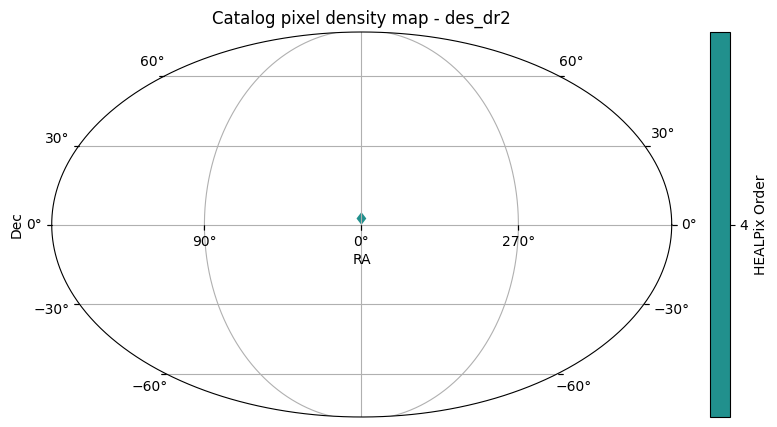

In [13]:
# Read the HATS catalog metadata, it does not load any data, just healpix pixels and other metadata
des_catalog = read_hats(DES_HATS_DIR)
plot_pixels(des_catalog)

# Convert Gaia DR3 to HATS

In [14]:
gaia_file = next(GAIA_DIR.glob("*.csv.gz"))
empty_astropy_table = ascii.read(gaia_file, format="ecsv", data_end=1)
empty_astropy_table.write(
    GAIA_SCHEMA_FILE,
    # Uncomment to overwrite existing schema file
    # overwrite=True,
)

In [15]:
gaia_args = ImportArguments(
    # sort columns are optional and works only if few objects are very close to each other
    sort_columns="source_id",
    ra_column="ra",
    dec_column="dec",
    # We select all Gaia ECSV files skipping the schema file
    input_file_list=list(GAIA_DIR.glob("*.csv.gz")),
    file_reader=CsvReader(
        comment="#",
        schema_file=GAIA_SCHEMA_FILE,
        compression="gzip",
    ),
    use_schema_file=GAIA_SCHEMA_FILE,
    output_artifact_name=GAIA_HATS_NAME,
    output_path=HATS_DIR,
)

pipeline_with_client(gaia_args, client)

Planning  :   0%|          | 0/4 [00:00<?, ?it/s]

Mapping   :   0%|          | 0/1 [00:00<?, ?it/s]

Binning   :   0%|          | 0/2 [00:00<?, ?it/s]

Splitting :   0%|          | 0/1 [00:00<?, ?it/s]

2025-05-20 09:39:04,241 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.36 GiB -- Worker memory limit: 3.20 GiB


Reducing  :   0%|          | 0/1 [00:00<?, ?it/s]

Finishing :   0%|          | 0/5 [00:00<?, ?it/s]

(<Figure size 1000x500 with 2 Axes>,
 <WCSAxes: title={'center': 'Catalog pixel density map - gaia_dr3'}>)

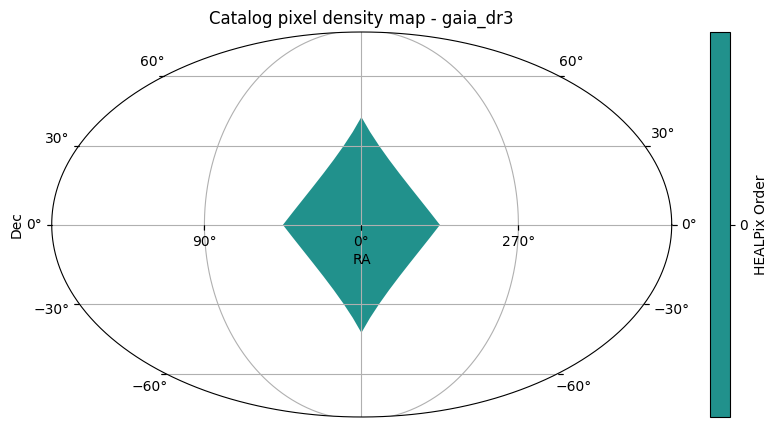

In [16]:
# It should be full sky for the whole catalog
gaia_catalog = read_hats(GAIA_HATS_DIR)
plot_pixels(gaia_catalog)

In [17]:
margin_cache_args = MarginCacheArguments(
    input_catalog_path=GAIA_HATS_DIR,
    output_path=HATS_DIR,
    margin_threshold=5.0,  # arcsec
    output_artifact_name=GAIA_MARGIN_CACHE_NAME,
)

pipeline_with_client(margin_cache_args, client)

Planning  :   0%|          | 0/3 [00:00<?, ?it/s]

Mapping   :   0%|          | 0/1 [00:00<?, ?it/s]

Binning   :   0%|          | 0/1 [00:00<?, ?it/s]

Reducing  :   0%|          | 0/12 [00:00<?, ?it/s]

Finishing :   0%|          | 0/4 [00:00<?, ?it/s]

In [18]:
des_catalog = lsdb.read_hats(DES_HATS_DIR)

# gaia_margin_cache_catalog = lsdb.read_hats(GAIA_MARGIN_CACHE_DIR)
gaia_catalog = lsdb.read_hats(GAIA_HATS_DIR)

xmatched = des_catalog.crossmatch(
    gaia_catalog,
    # Up to 1 arcsec distance, it is the default
    radius_arcsec=1.0,
    # Single closest object, it is the default
    n_neighbors=1,
    # Default would be to use names of the HATS catalogs
    suffixes=("_des", "_gaia"),
)

display(des_catalog)
display(gaia_catalog)
display(xmatched)

/Users/joaopassos/Software/HPMS_search/venv/lib/python3.11/site-packages/lsdb/dask/crossmatch_catalog_data.py:147: RuntimeWarning: Right catalog does not have a margin cache. Results may be incomplete and/or inaccurate.
  warnings.warn(


,COADD_OBJECT_ID,TILENAME,HPIX_32,HPIX_64,HPIX_1024,HPIX_4096,HPIX_16384,RA,DEC,ALPHAWIN_J2000,DELTAWIN_J2000,GALACTIC_L,GALACTIC_B,XWIN_IMAGE,YWIN_IMAGE,A_IMAGE,ERRA_IMAGE,B_IMAGE,ERRB_IMAGE,THETA_J2000,ERRTHETA_IMAGE,KRON_RADIUS,EBV_SFD98,MAG_AUTO_G_DERED,MAG_AUTO_R_DERED,MAG_AUTO_I_DERED,MAG_AUTO_Z_DERED,MAG_AUTO_Y_DERED,WAVG_MAG_PSF_G_DERED,WAVG_MAG_PSF_R_DERED,WAVG_MAG_PSF_I_DERED,WAVG_MAG_PSF_Z_DERED,WAVG_MAG_PSF_Y_DERED,EXTENDED_CLASS_COADD,EXTENDED_CLASS_WAVG,FLAGS_G,IMAFLAGS_ISO_G,NEPOCHS_G,FLAGS_R,IMAFLAGS_ISO_R,NEPOCHS_R,FLAGS_I,IMAFLAGS_ISO_I,NEPOCHS_I,FLAGS_Z,IMAFLAGS_ISO_Z,NEPOCHS_Z,FLAGS_Y,IMAFLAGS_ISO_Y,NEPOCHS_Y,XWIN_IMAGE_G,XWIN_IMAGE_R,XWIN_IMAGE_I,XWIN_IMAGE_Z,XWIN_IMAGE_Y,YWIN_IMAGE_G,YWIN_IMAGE_R,YWIN_IMAGE_I,YWIN_IMAGE_Z,YWIN_IMAGE_Y,X2WIN_IMAGE_G,X2WIN_IMAGE_R,X2WIN_IMAGE_I,X2WIN_IMAGE_Z,X2WIN_IMAGE_Y,Y2WIN_IMAGE_G,Y2WIN_IMAGE_R,Y2WIN_IMAGE_I,Y2WIN_IMAGE_Z,Y2WIN_IMAGE_Y,XYWIN_IMAGE_G,XYWIN_IMAGE_R,XYWIN_IMAGE_I,XYWIN_IMAGE_Z,XYWIN_IMAGE_Y,ERRX2WIN_IMAGE_G,ERRX2WIN_IMAGE_R,ERRX2WIN_IMAGE_I,ERRX2WIN_IMAGE_Z,ERRX2WIN_IMAGE_Y,ERRY2WIN_IMAGE_G,ERRY2WIN_IMAGE_R,ERRY2WIN_IMAGE_I,ERRY2WIN_IMAGE_Z,ERRY2WIN_IMAGE_Y,ERRXYWIN_IMAGE_G,ERRXYWIN_IMAGE_R,ERRXYWIN_IMAGE_I,ERRXYWIN_IMAGE_Z,ERRXYWIN_IMAGE_Y,AWIN_IMAGE_G,AWIN_IMAGE_R,AWIN_IMAGE_I,AWIN_IMAGE_Z,AWIN_IMAGE_Y,BWIN_IMAGE_G,BWIN_IMAGE_R,BWIN_IMAGE_I,BWIN_IMAGE_Z,BWIN_IMAGE_Y,THETAWIN_IMAGE_G,THETAWIN_IMAGE_R,THETAWIN_IMAGE_I,THETAWIN_IMAGE_Z,THETAWIN_IMAGE_Y,ERRAWIN_IMAGE_G,ERRAWIN_IMAGE_R,ERRAWIN_IMAGE_I,ERRAWIN_IMAGE_Z,ERRAWIN_IMAGE_Y,ERRBWIN_IMAGE_G,ERRBWIN_IMAGE_R,ERRBWIN_IMAGE_I,ERRBWIN_IMAGE_Z,ERRBWIN_IMAGE_Y,ERRTHETAWIN_IMAGE_G,ERRTHETAWIN_IMAGE_R,ERRTHETAWIN_IMAGE_I,ERRTHETAWIN_IMAGE_Z,ERRTHETAWIN_IMAGE_Y,FLUX_RADIUS_G,FLUX_RADIUS_R,FLUX_RADIUS_I,FLUX_RADIUS_Z,FLUX_RADIUS_Y,FWHM_IMAGE_G,FWHM_IMAGE_R,FWHM_IMAGE_I,FWHM_IMAGE_Z,FWHM_IMAGE_Y,ISOAREA_IMAGE_G,ISOAREA_IMAGE_R,ISOAREA_IMAGE_I,ISOAREA_IMAGE_Z,ISOAREA_IMAGE_Y,BACKGROUND_G,BACKGROUND_R,BACKGROUND_I,BACKGROUND_Z,BACKGROUND_Y,NITER_MODEL_G,NITER_MODEL_R,NITER_MODEL_I,NITER_MODEL_Z,NITER_MODEL_Y,KRON_RADIUS_G,KRON_RADIUS_R,KRON_RADIUS_I,KRON_RADIUS_Z,KRON_RADIUS_Y,MAG_AUTO_G,MAG_AUTO_R,MAG_AUTO_I,MAG_AUTO_Z,MAG_AUTO_Y,MAGERR_AUTO_G,MAGERR_AUTO_R,MAGERR_AUTO_I,MAGERR_AUTO_Z,MAGERR_AUTO_Y,WAVG_MAG_PSF_G,WAVG_MAG_PSF_R,WAVG_MAG_PSF_I,WAVG_MAG_PSF_Z,WAVG_MAG_PSF_Y,WAVG_MAGERR_PSF_G,WAVG_MAGERR_PSF_R,WAVG_MAGERR_PSF_I,WAVG_MAGERR_PSF_Z,WAVG_MAGERR_PSF_Y,FLUX_AUTO_G,FLUX_AUTO_R,FLUX_AUTO_I,FLUX_AUTO_Z,FLUX_AUTO_Y,FLUXERR_AUTO_G,FLUXERR_AUTO_R,FLUXERR_AUTO_I,FLUXERR_AUTO_Z,FLUXERR_AUTO_Y,WAVG_FLUX_PSF_G,WAVG_FLUX_PSF_R,WAVG_FLUX_PSF_I,WAVG_FLUX_PSF_Z,WAVG_FLUX_PSF_Y,WAVG_FLUXERR_PSF_G,WAVG_FLUXERR_PSF_R,WAVG_FLUXERR_PSF_I,WAVG_FLUXERR_PSF_Z,WAVG_FLUXERR_PSF_Y,CLASS_STAR_G,CLASS_STAR_R,CLASS_STAR_I,CLASS_STAR_Z,CLASS_STAR_Y,SPREAD_MODEL_G,SPREAD_MODEL_R,SPREAD_MODEL_I,SPREAD_MODEL_Z,SPREAD_MODEL_Y,WAVG_SPREAD_MODEL_G,WAVG_SPREAD_MODEL_R,WAVG_SPREAD_MODEL_I,WAVG_SPREAD_MODEL_Z,WAVG_SPREAD_MODEL_Y,SPREADERR_MODEL_G,SPREADERR_MODEL_R,SPREADERR_MODEL_I,SPREADERR_MODEL_Z,SPREADERR_MODEL_Y,WAVG_SPREADERR_MODEL_G,WAVG_SPREADERR_MODEL_R,WAVG_SPREADERR_MODEL_I,WAVG_SPREADERR_MODEL_Z,WAVG_SPREADERR_MODEL_Y
npartitions=1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
"Order: 4, Pixel: 1216",int64[pyarrow],string[pyarrow],int64[pyarrow],int64[pyarrow],int64[pyarrow],int64[pyarrow],int64[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],int16[pyarrow],int16[pyarrow],int16[pyarrow],int32[py

,solution_id,designation,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pm,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_primary_flag,nu_eff_used_in_astrometry,pseudocolour,pseudocolour_error,ra_pseudocolour_corr,dec_pseudocolour_corr,parallax_pseudocolour_corr,pmra_pseudocolour_corr,pmdec_pseudocolour_corr,astrometric_matched_transits,visibility_periods_used,astrometric_sigma5d_max,matched_transits,new_matched_transits,matched_transits_removed,ipd_gof_harmonic_amplitude,ipd_gof_harmonic_phase,ipd_frac_multi_peak,ipd_frac_odd_win,ruwe,scan_direction_strength_k1,scan_direction_strength_k2,scan_direction_strength_k3,scan_direction_strength_k4,scan_direction_mean_k1,scan_direction_mean_k2,scan_direction_mean_k3,scan_direction_mean_k4,duplicated_source,phot_g_n_obs,phot_g_mean_flux,phot_g_mean_flux_error,phot_g_mean_flux_over_error,phot_g_mean_mag,phot_bp_n_obs,phot_bp_mean_flux,phot_bp_mean_flux_error,phot_bp_mean_flux_over_error,phot_bp_mean_mag,phot_rp_n_obs,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_bp_rp_excess_factor,phot_bp_n_contaminated_transits,phot_bp_n_blended_transits,phot_rp_n_contaminated_transits,phot_rp_n_blended_transits,phot_proc_mode,bp_rp,bp_g,g_rp,radial_velocity,radial_velocity_error,rv_method_used,rv_nb_transits,rv_nb_deblended_transits,rv_visibility_periods_used,rv_expected_sig_to_noise,rv_renormalised_gof,rv_chisq_pvalue,rv_time_duration,rv_amplitude_robust,rv_template_teff,rv_template_logg,rv_template_fe_h,rv_atm_param_origin,vbroad,vbroad_error,vbroad_nb_transits,grvs_mag,grvs_mag_error,grvs_mag_nb_transits,rvs_spec_sig_to_noise,phot_variable_flag,l,b,ecl_lon,ecl_lat,in_qso_candidates,in_galaxy_candidates,non_single_star,has_xp_continuous,has_xp_sampled,has_rvs,has_epoch_photometry,has_epoch_rv,has_mcmc_gspphot,has_mcmc_msc,in_andromeda_survey,classprob_dsc_combmod_quasar,classprob_dsc_combmod_galaxy,classprob_dsc_combmod_star,teff_gspphot,teff_gspphot_lower,teff_gspphot_upper,logg_gspphot,logg_gspphot_lower,logg_gspphot_upper,mh_gspphot,mh_gspphot_lower,mh_gspphot_upper,distance_gspphot,distance_gspphot_lower,distance_gspphot_upper,azero_gspphot,azero_gspphot_lower,azero_gspphot_upper,ag_gspphot,ag_gspphot_lower,ag_gspphot_upper,ebpminrp_gspphot,ebpminrp_gspphot_lower,ebpminrp_gspphot_upper,libname_gspphot
npartitions=1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
"Order: 0, Pixel: 4",int64[pyarrow],string[pyarrow],int64[pyarrow],int64[pyarrow],double[pyarrow],double[pyarrow],float[pyarrow],double[pyarrow],float[pyarrow],double[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],double[pyarrow],float[pyarrow],double[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],int16[pyarrow],int16[pyarrow],int16[pyarrow],int16[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],int8[pyarrow],bool[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],int16[pyarrow],int16[pyarrow],float[pyarrow],int16[pyarrow],int16[pyarrow],int16[pyarrow],float[pyarrow],float[pyarrow],int8[pyarrow],int8[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],bool[pyarrow],int16[pyarrow],double[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],int16[pyarrow

,COADD_OBJECT_ID_des,TILENAME_des,HPIX_32_des,HPIX_64_des,HPIX_1024_des,HPIX_4096_des,HPIX_16384_des,RA_des,DEC_des,ALPHAWIN_J2000_des,DELTAWIN_J2000_des,GALACTIC_L_des,GALACTIC_B_des,XWIN_IMAGE_des,YWIN_IMAGE_des,A_IMAGE_des,ERRA_IMAGE_des,B_IMAGE_des,ERRB_IMAGE_des,THETA_J2000_des,ERRTHETA_IMAGE_des,KRON_RADIUS_des,EBV_SFD98_des,MAG_AUTO_G_DERED_des,MAG_AUTO_R_DERED_des,MAG_AUTO_I_DERED_des,MAG_AUTO_Z_DERED_des,MAG_AUTO_Y_DERED_des,WAVG_MAG_PSF_G_DERED_des,WAVG_MAG_PSF_R_DERED_des,WAVG_MAG_PSF_I_DERED_des,WAVG_MAG_PSF_Z_DERED_des,WAVG_MAG_PSF_Y_DERED_des,EXTENDED_CLASS_COADD_des,EXTENDED_CLASS_WAVG_des,FLAGS_G_des,IMAFLAGS_ISO_G_des,NEPOCHS_G_des,FLAGS_R_des,IMAFLAGS_ISO_R_des,NEPOCHS_R_des,FLAGS_I_des,IMAFLAGS_ISO_I_des,NEPOCHS_I_des,FLAGS_Z_des,IMAFLAGS_ISO_Z_des,NEPOCHS_Z_des,FLAGS_Y_des,IMAFLAGS_ISO_Y_des,NEPOCHS_Y_des,XWIN_IMAGE_G_des,XWIN_IMAGE_R_des,XWIN_IMAGE_I_des,XWIN_IMAGE_Z_des,XWIN_IMAGE_Y_des,YWIN_IMAGE_G_des,YWIN_IMAGE_R_des,YWIN_IMAGE_I_des,YWIN_IMAGE_Z_des,YWIN_IMAGE_Y_des,X2WIN_IMAGE_G_des,X2WIN_IMAGE_R_des,X2WIN_IMAGE_I_des,X2WIN_IMAGE_Z_des,X2WIN_IMAGE_Y_des,Y2WIN_IMAGE_G_des,Y2WIN_IMAGE_R_des,Y2WIN_IMAGE_I_des,Y2WIN_IMAGE_Z_des,Y2WIN_IMAGE_Y_des,XYWIN_IMAGE_G_des,XYWIN_IMAGE_R_des,XYWIN_IMAGE_I_des,XYWIN_IMAGE_Z_des,XYWIN_IMAGE_Y_des,ERRX2WIN_IMAGE_G_des,ERRX2WIN_IMAGE_R_des,ERRX2WIN_IMAGE_I_des,ERRX2WIN_IMAGE_Z_des,ERRX2WIN_IMAGE_Y_des,ERRY2WIN_IMAGE_G_des,ERRY2WIN_IMAGE_R_des,ERRY2WIN_IMAGE_I_des,ERRY2WIN_IMAGE_Z_des,ERRY2WIN_IMAGE_Y_des,ERRXYWIN_IMAGE_G_des,ERRXYWIN_IMAGE_R_des,ERRXYWIN_IMAGE_I_des,ERRXYWIN_IMAGE_Z_des,ERRXYWIN_IMAGE_Y_des,AWIN_IMAGE_G_des,AWIN_IMAGE_R_des,AWIN_IMAGE_I_des,AWIN_IMAGE_Z_des,AWIN_IMAGE_Y_des,BWIN_IMAGE_G_des,BWIN_IMAGE_R_des,BWIN_IMAGE_I_des,BWIN_IMAGE_Z_des,BWIN_IMAGE_Y_des,THETAWIN_IMAGE_G_des,THETAWIN_IMAGE_R_des,THETAWIN_IMAGE_I_des,THETAWIN_IMAGE_Z_des,THETAWIN_IMAGE_Y_des,ERRAWIN_IMAGE_G_des,ERRAWIN_IMAGE_R_des,ERRAWIN_IMAGE_I_des,ERRAWIN_IMAGE_Z_des,ERRAWIN_IMAGE_Y_des,ERRBWIN_IMAGE_G_des,ERRBWIN_IMAGE_R_des,ERRBWIN_IMAGE_I_des,ERRBWIN_IMAGE_Z_des,ERRBWIN_IMAGE_Y_des,ERRTHETAWIN_IMAGE_G_des,ERRTHETAWIN_IMAGE_R_des,ERRTHETAWIN_IMAGE_I_des,ERRTHETAWIN_IMAGE_Z_des,ERRTHETAWIN_IMAGE_Y_des,FLUX_RADIUS_G_des,FLUX_RADIUS_R_des,FLUX_RADIUS_I_des,FLUX_RADIUS_Z_des,FLUX_RADIUS_Y_des,FWHM_IMAGE_G_des,FWHM_IMAGE_R_des,FWHM_IMAGE_I_des,FWHM_IMAGE_Z_des,FWHM_IMAGE_Y_des,ISOAREA_IMAGE_G_des,ISOAREA_IMAGE_R_des,ISOAREA_IMAGE_I_des,ISOAREA_IMAGE_Z_des,ISOAREA_IMAGE_Y_des,BACKGROUND_G_des,BACKGROUND_R_des,BACKGROUND_I_des,BACKGROUND_Z_des,BACKGROUND_Y_des,NITER_MODEL_G_des,NITER_MODEL_R_des,NITER_MODEL_I_des,NITER_MODEL_Z_des,NITER_MODEL_Y_des,KRON_RADIUS_G_des,KRON_RADIUS_R_des,KRON_RADIUS_I_des,KRON_RADIUS_Z_des,KRON_RADIUS_Y_des,MAG_AUTO_G_des,MAG_AUTO_R_des,MAG_AUTO_I_des,MAG_AUTO_Z_des,MAG_AUTO_Y_des,MAGERR_AUTO_G_des,MAGERR_AUTO_R_des,MAGERR_AUTO_I_des,MAGERR_AUTO_Z_des,MAGERR_AUTO_Y_des,WAVG_MAG_PSF_G_des,WAVG_MAG_PSF_R_des,WAVG_MAG_PSF_I_des,WAVG_MAG_PSF_Z_des,WAVG_MAG_PSF_Y_des,WAVG_MAGERR_PSF_G_des,WAVG_MAGERR_PSF_R_des,WAVG_MAGERR_PSF_I_des,WAVG_MAGERR_PSF_Z_des,WAVG_MAGERR_PSF_Y_des,FLUX_AUTO_G_des,FLUX_AUTO_R_des,FLUX_AUTO_I_des,FLUX_AUTO_Z_des,FLUX_AUTO_Y_des,FLUXERR_AUTO_G_des,FLUXERR_AUTO_R_des,FLUXERR_AUTO_I_des,FLUXERR_AUTO_Z_des,FLUXERR_AUTO_Y_des,WAVG_FLUX_PSF_G_des,WAVG_FLUX_PSF_R_des,WAVG_FLUX_PSF_I_des,WAVG_FLUX_PSF_Z_des,WAVG_FLUX_PSF_Y_des,WAVG_FLUXERR_PSF_G_des,WAVG_FLUXERR_PSF_R_des,WAVG_FLUXERR_PSF_I_des,WAVG_FLUXERR_PSF_Z_des,WAVG_FLUXERR_PSF_Y_des,CLASS_STAR_G_des,CLASS_STAR_R_des,CLASS_STAR_I_des,CLASS_STAR_Z_des,CLASS_STAR_Y_des,SPREAD_MODEL_G_des,SPREAD_MODEL_R_des,SPREAD_MODEL_I_des,SPREAD_MODEL_Z_des,SPREAD_MODEL_Y_des,WAVG_SPREAD_MODEL_G_des,WAVG_SPREAD_MODEL_R_des,WAVG_SPREAD_MODEL_I_des,WAVG_SPREAD_MODEL_Z_des,WAVG_SPREAD_MODEL_Y_des,SPREADERR_MODEL_G_des,SPREADERR_MODEL_R_des,SPREADERR_MODEL_I_des,SPREADERR_MODEL_Z_des,SPREADERR_MODEL_Y_des,WAVG_SPREADERR_MODEL_G_des,WAVG_SPREADERR_MODEL_R_des,WAVG_SPREADERR_MODEL_I_des,WAVG_SPREADERR_MODEL_Z

In [16]:
xmatched

,COADD_OBJECT_ID_des,TILENAME_des,HPIX_32_des,HPIX_64_des,HPIX_1024_des,HPIX_4096_des,HPIX_16384_des,RA_des,DEC_des,ALPHAWIN_J2000_des,DELTAWIN_J2000_des,GALACTIC_L_des,GALACTIC_B_des,XWIN_IMAGE_des,YWIN_IMAGE_des,A_IMAGE_des,ERRA_IMAGE_des,B_IMAGE_des,ERRB_IMAGE_des,THETA_J2000_des,ERRTHETA_IMAGE_des,KRON_RADIUS_des,EBV_SFD98_des,MAG_AUTO_G_DERED_des,MAG_AUTO_R_DERED_des,MAG_AUTO_I_DERED_des,MAG_AUTO_Z_DERED_des,MAG_AUTO_Y_DERED_des,WAVG_MAG_PSF_G_DERED_des,WAVG_MAG_PSF_R_DERED_des,WAVG_MAG_PSF_I_DERED_des,WAVG_MAG_PSF_Z_DERED_des,WAVG_MAG_PSF_Y_DERED_des,EXTENDED_CLASS_COADD_des,EXTENDED_CLASS_WAVG_des,FLAGS_G_des,IMAFLAGS_ISO_G_des,NEPOCHS_G_des,FLAGS_R_des,IMAFLAGS_ISO_R_des,NEPOCHS_R_des,FLAGS_I_des,IMAFLAGS_ISO_I_des,NEPOCHS_I_des,FLAGS_Z_des,IMAFLAGS_ISO_Z_des,NEPOCHS_Z_des,FLAGS_Y_des,IMAFLAGS_ISO_Y_des,NEPOCHS_Y_des,XWIN_IMAGE_G_des,XWIN_IMAGE_R_des,XWIN_IMAGE_I_des,XWIN_IMAGE_Z_des,XWIN_IMAGE_Y_des,YWIN_IMAGE_G_des,YWIN_IMAGE_R_des,YWIN_IMAGE_I_des,YWIN_IMAGE_Z_des,YWIN_IMAGE_Y_des,X2WIN_IMAGE_G_des,X2WIN_IMAGE_R_des,X2WIN_IMAGE_I_des,X2WIN_IMAGE_Z_des,X2WIN_IMAGE_Y_des,Y2WIN_IMAGE_G_des,Y2WIN_IMAGE_R_des,Y2WIN_IMAGE_I_des,Y2WIN_IMAGE_Z_des,Y2WIN_IMAGE_Y_des,XYWIN_IMAGE_G_des,XYWIN_IMAGE_R_des,XYWIN_IMAGE_I_des,XYWIN_IMAGE_Z_des,XYWIN_IMAGE_Y_des,ERRX2WIN_IMAGE_G_des,ERRX2WIN_IMAGE_R_des,ERRX2WIN_IMAGE_I_des,ERRX2WIN_IMAGE_Z_des,ERRX2WIN_IMAGE_Y_des,ERRY2WIN_IMAGE_G_des,ERRY2WIN_IMAGE_R_des,ERRY2WIN_IMAGE_I_des,ERRY2WIN_IMAGE_Z_des,ERRY2WIN_IMAGE_Y_des,ERRXYWIN_IMAGE_G_des,ERRXYWIN_IMAGE_R_des,ERRXYWIN_IMAGE_I_des,ERRXYWIN_IMAGE_Z_des,ERRXYWIN_IMAGE_Y_des,AWIN_IMAGE_G_des,AWIN_IMAGE_R_des,AWIN_IMAGE_I_des,AWIN_IMAGE_Z_des,AWIN_IMAGE_Y_des,BWIN_IMAGE_G_des,BWIN_IMAGE_R_des,BWIN_IMAGE_I_des,BWIN_IMAGE_Z_des,BWIN_IMAGE_Y_des,THETAWIN_IMAGE_G_des,THETAWIN_IMAGE_R_des,THETAWIN_IMAGE_I_des,THETAWIN_IMAGE_Z_des,THETAWIN_IMAGE_Y_des,ERRAWIN_IMAGE_G_des,ERRAWIN_IMAGE_R_des,ERRAWIN_IMAGE_I_des,ERRAWIN_IMAGE_Z_des,ERRAWIN_IMAGE_Y_des,ERRBWIN_IMAGE_G_des,ERRBWIN_IMAGE_R_des,ERRBWIN_IMAGE_I_des,ERRBWIN_IMAGE_Z_des,ERRBWIN_IMAGE_Y_des,ERRTHETAWIN_IMAGE_G_des,ERRTHETAWIN_IMAGE_R_des,ERRTHETAWIN_IMAGE_I_des,ERRTHETAWIN_IMAGE_Z_des,ERRTHETAWIN_IMAGE_Y_des,FLUX_RADIUS_G_des,FLUX_RADIUS_R_des,FLUX_RADIUS_I_des,FLUX_RADIUS_Z_des,FLUX_RADIUS_Y_des,FWHM_IMAGE_G_des,FWHM_IMAGE_R_des,FWHM_IMAGE_I_des,FWHM_IMAGE_Z_des,FWHM_IMAGE_Y_des,ISOAREA_IMAGE_G_des,ISOAREA_IMAGE_R_des,ISOAREA_IMAGE_I_des,ISOAREA_IMAGE_Z_des,ISOAREA_IMAGE_Y_des,BACKGROUND_G_des,BACKGROUND_R_des,BACKGROUND_I_des,BACKGROUND_Z_des,BACKGROUND_Y_des,NITER_MODEL_G_des,NITER_MODEL_R_des,NITER_MODEL_I_des,NITER_MODEL_Z_des,NITER_MODEL_Y_des,KRON_RADIUS_G_des,KRON_RADIUS_R_des,KRON_RADIUS_I_des,KRON_RADIUS_Z_des,KRON_RADIUS_Y_des,MAG_AUTO_G_des,MAG_AUTO_R_des,MAG_AUTO_I_des,MAG_AUTO_Z_des,MAG_AUTO_Y_des,MAGERR_AUTO_G_des,MAGERR_AUTO_R_des,MAGERR_AUTO_I_des,MAGERR_AUTO_Z_des,MAGERR_AUTO_Y_des,WAVG_MAG_PSF_G_des,WAVG_MAG_PSF_R_des,WAVG_MAG_PSF_I_des,WAVG_MAG_PSF_Z_des,WAVG_MAG_PSF_Y_des,WAVG_MAGERR_PSF_G_des,WAVG_MAGERR_PSF_R_des,WAVG_MAGERR_PSF_I_des,WAVG_MAGERR_PSF_Z_des,WAVG_MAGERR_PSF_Y_des,FLUX_AUTO_G_des,FLUX_AUTO_R_des,FLUX_AUTO_I_des,FLUX_AUTO_Z_des,FLUX_AUTO_Y_des,FLUXERR_AUTO_G_des,FLUXERR_AUTO_R_des,FLUXERR_AUTO_I_des,FLUXERR_AUTO_Z_des,FLUXERR_AUTO_Y_des,WAVG_FLUX_PSF_G_des,WAVG_FLUX_PSF_R_des,WAVG_FLUX_PSF_I_des,WAVG_FLUX_PSF_Z_des,WAVG_FLUX_PSF_Y_des,WAVG_FLUXERR_PSF_G_des,WAVG_FLUXERR_PSF_R_des,WAVG_FLUXERR_PSF_I_des,WAVG_FLUXERR_PSF_Z_des,WAVG_FLUXERR_PSF_Y_des,CLASS_STAR_G_des,CLASS_STAR_R_des,CLASS_STAR_I_des,CLASS_STAR_Z_des,CLASS_STAR_Y_des,SPREAD_MODEL_G_des,SPREAD_MODEL_R_des,SPREAD_MODEL_I_des,SPREAD_MODEL_Z_des,SPREAD_MODEL_Y_des,WAVG_SPREAD_MODEL_G_des,WAVG_SPREAD_MODEL_R_des,WAVG_SPREAD_MODEL_I_des,WAVG_SPREAD_MODEL_Z_des,WAVG_SPREAD_MODEL_Y_des,SPREADERR_MODEL_G_des,SPREADERR_MODEL_R_des,SPREADERR_MODEL_I_des,SPREADERR_MODEL_Z_des,SPREADERR_MODEL_Y_des,WAVG_SPREADERR_MODEL_G_des,WAVG_SPREADERR_MODEL_R_des,WAVG_SPREADERR_MODEL_I_des,WAVG_SPREADERR_MODEL_Z

In [19]:
xmatched.to_hats(XMATCH_DIR)

xmatched

,COADD_OBJECT_ID_des,TILENAME_des,HPIX_32_des,HPIX_64_des,HPIX_1024_des,HPIX_4096_des,HPIX_16384_des,RA_des,DEC_des,ALPHAWIN_J2000_des,DELTAWIN_J2000_des,GALACTIC_L_des,GALACTIC_B_des,XWIN_IMAGE_des,YWIN_IMAGE_des,A_IMAGE_des,ERRA_IMAGE_des,B_IMAGE_des,ERRB_IMAGE_des,THETA_J2000_des,ERRTHETA_IMAGE_des,KRON_RADIUS_des,EBV_SFD98_des,MAG_AUTO_G_DERED_des,MAG_AUTO_R_DERED_des,MAG_AUTO_I_DERED_des,MAG_AUTO_Z_DERED_des,MAG_AUTO_Y_DERED_des,WAVG_MAG_PSF_G_DERED_des,WAVG_MAG_PSF_R_DERED_des,WAVG_MAG_PSF_I_DERED_des,WAVG_MAG_PSF_Z_DERED_des,WAVG_MAG_PSF_Y_DERED_des,EXTENDED_CLASS_COADD_des,EXTENDED_CLASS_WAVG_des,FLAGS_G_des,IMAFLAGS_ISO_G_des,NEPOCHS_G_des,FLAGS_R_des,IMAFLAGS_ISO_R_des,NEPOCHS_R_des,FLAGS_I_des,IMAFLAGS_ISO_I_des,NEPOCHS_I_des,FLAGS_Z_des,IMAFLAGS_ISO_Z_des,NEPOCHS_Z_des,FLAGS_Y_des,IMAFLAGS_ISO_Y_des,NEPOCHS_Y_des,XWIN_IMAGE_G_des,XWIN_IMAGE_R_des,XWIN_IMAGE_I_des,XWIN_IMAGE_Z_des,XWIN_IMAGE_Y_des,YWIN_IMAGE_G_des,YWIN_IMAGE_R_des,YWIN_IMAGE_I_des,YWIN_IMAGE_Z_des,YWIN_IMAGE_Y_des,X2WIN_IMAGE_G_des,X2WIN_IMAGE_R_des,X2WIN_IMAGE_I_des,X2WIN_IMAGE_Z_des,X2WIN_IMAGE_Y_des,Y2WIN_IMAGE_G_des,Y2WIN_IMAGE_R_des,Y2WIN_IMAGE_I_des,Y2WIN_IMAGE_Z_des,Y2WIN_IMAGE_Y_des,XYWIN_IMAGE_G_des,XYWIN_IMAGE_R_des,XYWIN_IMAGE_I_des,XYWIN_IMAGE_Z_des,XYWIN_IMAGE_Y_des,ERRX2WIN_IMAGE_G_des,ERRX2WIN_IMAGE_R_des,ERRX2WIN_IMAGE_I_des,ERRX2WIN_IMAGE_Z_des,ERRX2WIN_IMAGE_Y_des,ERRY2WIN_IMAGE_G_des,ERRY2WIN_IMAGE_R_des,ERRY2WIN_IMAGE_I_des,ERRY2WIN_IMAGE_Z_des,ERRY2WIN_IMAGE_Y_des,ERRXYWIN_IMAGE_G_des,ERRXYWIN_IMAGE_R_des,ERRXYWIN_IMAGE_I_des,ERRXYWIN_IMAGE_Z_des,ERRXYWIN_IMAGE_Y_des,AWIN_IMAGE_G_des,AWIN_IMAGE_R_des,AWIN_IMAGE_I_des,AWIN_IMAGE_Z_des,AWIN_IMAGE_Y_des,BWIN_IMAGE_G_des,BWIN_IMAGE_R_des,BWIN_IMAGE_I_des,BWIN_IMAGE_Z_des,BWIN_IMAGE_Y_des,THETAWIN_IMAGE_G_des,THETAWIN_IMAGE_R_des,THETAWIN_IMAGE_I_des,THETAWIN_IMAGE_Z_des,THETAWIN_IMAGE_Y_des,ERRAWIN_IMAGE_G_des,ERRAWIN_IMAGE_R_des,ERRAWIN_IMAGE_I_des,ERRAWIN_IMAGE_Z_des,ERRAWIN_IMAGE_Y_des,ERRBWIN_IMAGE_G_des,ERRBWIN_IMAGE_R_des,ERRBWIN_IMAGE_I_des,ERRBWIN_IMAGE_Z_des,ERRBWIN_IMAGE_Y_des,ERRTHETAWIN_IMAGE_G_des,ERRTHETAWIN_IMAGE_R_des,ERRTHETAWIN_IMAGE_I_des,ERRTHETAWIN_IMAGE_Z_des,ERRTHETAWIN_IMAGE_Y_des,FLUX_RADIUS_G_des,FLUX_RADIUS_R_des,FLUX_RADIUS_I_des,FLUX_RADIUS_Z_des,FLUX_RADIUS_Y_des,FWHM_IMAGE_G_des,FWHM_IMAGE_R_des,FWHM_IMAGE_I_des,FWHM_IMAGE_Z_des,FWHM_IMAGE_Y_des,ISOAREA_IMAGE_G_des,ISOAREA_IMAGE_R_des,ISOAREA_IMAGE_I_des,ISOAREA_IMAGE_Z_des,ISOAREA_IMAGE_Y_des,BACKGROUND_G_des,BACKGROUND_R_des,BACKGROUND_I_des,BACKGROUND_Z_des,BACKGROUND_Y_des,NITER_MODEL_G_des,NITER_MODEL_R_des,NITER_MODEL_I_des,NITER_MODEL_Z_des,NITER_MODEL_Y_des,KRON_RADIUS_G_des,KRON_RADIUS_R_des,KRON_RADIUS_I_des,KRON_RADIUS_Z_des,KRON_RADIUS_Y_des,MAG_AUTO_G_des,MAG_AUTO_R_des,MAG_AUTO_I_des,MAG_AUTO_Z_des,MAG_AUTO_Y_des,MAGERR_AUTO_G_des,MAGERR_AUTO_R_des,MAGERR_AUTO_I_des,MAGERR_AUTO_Z_des,MAGERR_AUTO_Y_des,WAVG_MAG_PSF_G_des,WAVG_MAG_PSF_R_des,WAVG_MAG_PSF_I_des,WAVG_MAG_PSF_Z_des,WAVG_MAG_PSF_Y_des,WAVG_MAGERR_PSF_G_des,WAVG_MAGERR_PSF_R_des,WAVG_MAGERR_PSF_I_des,WAVG_MAGERR_PSF_Z_des,WAVG_MAGERR_PSF_Y_des,FLUX_AUTO_G_des,FLUX_AUTO_R_des,FLUX_AUTO_I_des,FLUX_AUTO_Z_des,FLUX_AUTO_Y_des,FLUXERR_AUTO_G_des,FLUXERR_AUTO_R_des,FLUXERR_AUTO_I_des,FLUXERR_AUTO_Z_des,FLUXERR_AUTO_Y_des,WAVG_FLUX_PSF_G_des,WAVG_FLUX_PSF_R_des,WAVG_FLUX_PSF_I_des,WAVG_FLUX_PSF_Z_des,WAVG_FLUX_PSF_Y_des,WAVG_FLUXERR_PSF_G_des,WAVG_FLUXERR_PSF_R_des,WAVG_FLUXERR_PSF_I_des,WAVG_FLUXERR_PSF_Z_des,WAVG_FLUXERR_PSF_Y_des,CLASS_STAR_G_des,CLASS_STAR_R_des,CLASS_STAR_I_des,CLASS_STAR_Z_des,CLASS_STAR_Y_des,SPREAD_MODEL_G_des,SPREAD_MODEL_R_des,SPREAD_MODEL_I_des,SPREAD_MODEL_Z_des,SPREAD_MODEL_Y_des,WAVG_SPREAD_MODEL_G_des,WAVG_SPREAD_MODEL_R_des,WAVG_SPREAD_MODEL_I_des,WAVG_SPREAD_MODEL_Z_des,WAVG_SPREAD_MODEL_Y_des,SPREADERR_MODEL_G_des,SPREADERR_MODEL_R_des,SPREADERR_MODEL_I_des,SPREADERR_MODEL_Z_des,SPREADERR_MODEL_Y_des,WAVG_SPREADERR_MODEL_G_des,WAVG_SPREADERR_MODEL_R_des,WAVG_SPREADERR_MODEL_I_des,WAVG_SPREADERR_MODEL_Z

In [20]:
lsdb.read_hats(XMATCH_DIR).head()

,COADD_OBJECT_ID_des,TILENAME_des,HPIX_32_des,HPIX_64_des,HPIX_1024_des,HPIX_4096_des,HPIX_16384_des,RA_des,DEC_des,ALPHAWIN_J2000_des,DELTAWIN_J2000_des,GALACTIC_L_des,GALACTIC_B_des,XWIN_IMAGE_des,YWIN_IMAGE_des,A_IMAGE_des,ERRA_IMAGE_des,B_IMAGE_des,ERRB_IMAGE_des,THETA_J2000_des,ERRTHETA_IMAGE_des,KRON_RADIUS_des,EBV_SFD98_des,MAG_AUTO_G_DERED_des,MAG_AUTO_R_DERED_des,MAG_AUTO_I_DERED_des,MAG_AUTO_Z_DERED_des,MAG_AUTO_Y_DERED_des,WAVG_MAG_PSF_G_DERED_des,WAVG_MAG_PSF_R_DERED_des,WAVG_MAG_PSF_I_DERED_des,WAVG_MAG_PSF_Z_DERED_des,WAVG_MAG_PSF_Y_DERED_des,EXTENDED_CLASS_COADD_des,EXTENDED_CLASS_WAVG_des,FLAGS_G_des,IMAFLAGS_ISO_G_des,NEPOCHS_G_des,FLAGS_R_des,IMAFLAGS_ISO_R_des,NEPOCHS_R_des,FLAGS_I_des,IMAFLAGS_ISO_I_des,NEPOCHS_I_des,FLAGS_Z_des,IMAFLAGS_ISO_Z_des,NEPOCHS_Z_des,FLAGS_Y_des,IMAFLAGS_ISO_Y_des,NEPOCHS_Y_des,XWIN_IMAGE_G_des,XWIN_IMAGE_R_des,XWIN_IMAGE_I_des,XWIN_IMAGE_Z_des,XWIN_IMAGE_Y_des,YWIN_IMAGE_G_des,YWIN_IMAGE_R_des,YWIN_IMAGE_I_des,YWIN_IMAGE_Z_des,YWIN_IMAGE_Y_des,X2WIN_IMAGE_G_des,X2WIN_IMAGE_R_des,X2WIN_IMAGE_I_des,X2WIN_IMAGE_Z_des,X2WIN_IMAGE_Y_des,Y2WIN_IMAGE_G_des,Y2WIN_IMAGE_R_des,Y2WIN_IMAGE_I_des,Y2WIN_IMAGE_Z_des,Y2WIN_IMAGE_Y_des,XYWIN_IMAGE_G_des,XYWIN_IMAGE_R_des,XYWIN_IMAGE_I_des,XYWIN_IMAGE_Z_des,XYWIN_IMAGE_Y_des,ERRX2WIN_IMAGE_G_des,ERRX2WIN_IMAGE_R_des,ERRX2WIN_IMAGE_I_des,ERRX2WIN_IMAGE_Z_des,ERRX2WIN_IMAGE_Y_des,ERRY2WIN_IMAGE_G_des,ERRY2WIN_IMAGE_R_des,ERRY2WIN_IMAGE_I_des,ERRY2WIN_IMAGE_Z_des,ERRY2WIN_IMAGE_Y_des,ERRXYWIN_IMAGE_G_des,ERRXYWIN_IMAGE_R_des,ERRXYWIN_IMAGE_I_des,ERRXYWIN_IMAGE_Z_des,ERRXYWIN_IMAGE_Y_des,AWIN_IMAGE_G_des,AWIN_IMAGE_R_des,AWIN_IMAGE_I_des,AWIN_IMAGE_Z_des,AWIN_IMAGE_Y_des,BWIN_IMAGE_G_des,BWIN_IMAGE_R_des,BWIN_IMAGE_I_des,BWIN_IMAGE_Z_des,BWIN_IMAGE_Y_des,THETAWIN_IMAGE_G_des,THETAWIN_IMAGE_R_des,THETAWIN_IMAGE_I_des,THETAWIN_IMAGE_Z_des,THETAWIN_IMAGE_Y_des,ERRAWIN_IMAGE_G_des,ERRAWIN_IMAGE_R_des,ERRAWIN_IMAGE_I_des,ERRAWIN_IMAGE_Z_des,ERRAWIN_IMAGE_Y_des,ERRBWIN_IMAGE_G_des,ERRBWIN_IMAGE_R_des,ERRBWIN_IMAGE_I_des,ERRBWIN_IMAGE_Z_des,ERRBWIN_IMAGE_Y_des,ERRTHETAWIN_IMAGE_G_des,ERRTHETAWIN_IMAGE_R_des,ERRTHETAWIN_IMAGE_I_des,ERRTHETAWIN_IMAGE_Z_des,ERRTHETAWIN_IMAGE_Y_des,FLUX_RADIUS_G_des,FLUX_RADIUS_R_des,FLUX_RADIUS_I_des,FLUX_RADIUS_Z_des,FLUX_RADIUS_Y_des,FWHM_IMAGE_G_des,FWHM_IMAGE_R_des,FWHM_IMAGE_I_des,FWHM_IMAGE_Z_des,FWHM_IMAGE_Y_des,ISOAREA_IMAGE_G_des,ISOAREA_IMAGE_R_des,ISOAREA_IMAGE_I_des,ISOAREA_IMAGE_Z_des,ISOAREA_IMAGE_Y_des,BACKGROUND_G_des,BACKGROUND_R_des,BACKGROUND_I_des,BACKGROUND_Z_des,BACKGROUND_Y_des,NITER_MODEL_G_des,NITER_MODEL_R_des,NITER_MODEL_I_des,NITER_MODEL_Z_des,NITER_MODEL_Y_des,KRON_RADIUS_G_des,KRON_RADIUS_R_des,KRON_RADIUS_I_des,KRON_RADIUS_Z_des,KRON_RADIUS_Y_des,MAG_AUTO_G_des,MAG_AUTO_R_des,MAG_AUTO_I_des,MAG_AUTO_Z_des,MAG_AUTO_Y_des,MAGERR_AUTO_G_des,MAGERR_AUTO_R_des,MAGERR_AUTO_I_des,MAGERR_AUTO_Z_des,MAGERR_AUTO_Y_des,WAVG_MAG_PSF_G_des,WAVG_MAG_PSF_R_des,WAVG_MAG_PSF_I_des,WAVG_MAG_PSF_Z_des,WAVG_MAG_PSF_Y_des,WAVG_MAGERR_PSF_G_des,WAVG_MAGERR_PSF_R_des,WAVG_MAGERR_PSF_I_des,WAVG_MAGERR_PSF_Z_des,WAVG_MAGERR_PSF_Y_des,FLUX_AUTO_G_des,FLUX_AUTO_R_des,FLUX_AUTO_I_des,FLUX_AUTO_Z_des,FLUX_AUTO_Y_des,FLUXERR_AUTO_G_des,FLUXERR_AUTO_R_des,FLUXERR_AUTO_I_des,FLUXERR_AUTO_Z_des,FLUXERR_AUTO_Y_des,WAVG_FLUX_PSF_G_des,WAVG_FLUX_PSF_R_des,WAVG_FLUX_PSF_I_des,WAVG_FLUX_PSF_Z_des,WAVG_FLUX_PSF_Y_des,WAVG_FLUXERR_PSF_G_des,WAVG_FLUXERR_PSF_R_des,WAVG_FLUXERR_PSF_I_des,WAVG_FLUXERR_PSF_Z_des,WAVG_FLUXERR_PSF_Y_des,CLASS_STAR_G_des,CLASS_STAR_R_des,CLASS_STAR_I_des,CLASS_STAR_Z_des,CLASS_STAR_Y_des,SPREAD_MODEL_G_des,SPREAD_MODEL_R_des,SPREAD_MODEL_I_des,SPREAD_MODEL_Z_des,SPREAD_MODEL_Y_des,WAVG_SPREAD_MODEL_G_des,WAVG_SPREAD_MODEL_R_des,WAVG_SPREAD_MODEL_I_des,WAVG_SPREAD_MODEL_Z_des,WAVG_SPREAD_MODEL_Y_des,SPREADERR_MODEL_G_des,SPREADERR_MODEL_R_des,SPREADERR_MODEL_I_des,SPREADERR_MODEL_Z_des,SPREADERR_MODEL_Y_des,WAVG_SPREADERR_MODEL_G_des,WAVG_SPREADERR_MODEL_R_des,WAVG_SPREADERR_MODEL_I_des,WAVG_SPREADERR_MODEL_Z

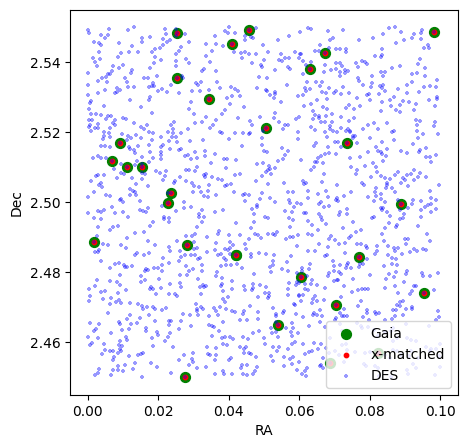

In [21]:
ra_range = [0.0, 0.1]
dec_range = [2.45, 2.55]

des_box = des_catalog.box_search(ra=ra_range, dec=dec_range).compute()
gaia_box = gaia_catalog.box_search(ra=ra_range, dec=dec_range).compute()
xmatch_box = xmatched.box_search(ra=ra_range, dec=dec_range).compute()

ra_des = np.where(des_box["RA"] > 180, des_box["RA"] - 360, des_box["RA"])
ra_gaia = np.where(gaia_box["ra"] > 180, gaia_box["ra"] - 360, gaia_box["ra"])
ra_x_gaia = np.where(xmatch_box["ra_gaia"] > 180, xmatch_box["ra_gaia"] - 360, xmatch_box["ra_gaia"])

plt.figure(figsize=(5, 5))
plt.scatter(ra_gaia, gaia_box["dec"], s=50, alpha=1.0, color="green", label="Gaia")
plt.scatter(ra_x_gaia, xmatch_box["dec_gaia"], s=10, alpha=1.0, color="red", label="x-matched")
plt.scatter(ra_des, des_box["DEC"], s=10, alpha=0.4, marker="+", color="blue", label="DES")
plt.xlabel("RA")
plt.ylabel("Dec")
plt.legend()

/Users/joaopassos/Software/HPMS_search/venv/lib/python3.11/site-packages/dask/dataframe/dask_expr/_collection.py:1430: UserWarning: Dask currently has limited support for converting pandas extension dtypes to arrays. Converting double[pyarrow] to object dtype.
  warnings.warn(
/Users/joaopassos/Software/HPMS_search/venv/lib/python3.11/site-packages/dask/dataframe/dask_expr/_collection.py:1430: UserWarning: Dask currently has limited support for converting pandas extension dtypes to arrays. Converting double[pyarrow] to object dtype.
  warnings.warn(


Text(0.5, 1.0, 'Absolute magnitude — color diagram')

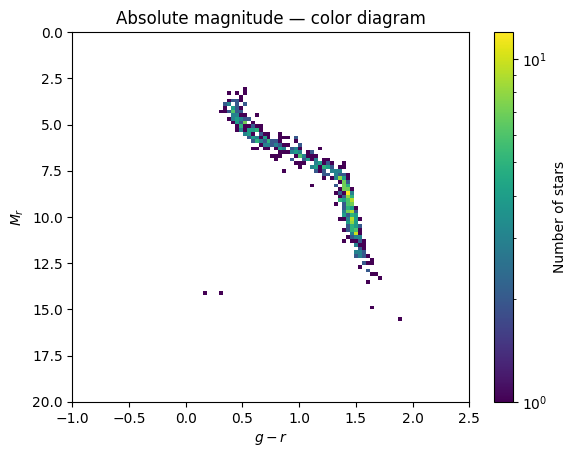

In [22]:
# Read the cross-matched catalog, just like we did before for Gaia and DES,
# but keeping few columns only.
xmatched_from_disk = lsdb.read_hats(
    XMATCH_DIR,
    columns=[
        "parallax_gaia",
        "parallax_over_error_gaia",
        "WAVG_MAG_PSF_G_des",
        "WAVG_MAG_PSF_R_des",
    ],
)

# Apply quality flags
filtered = xmatched.query(
    "parallax_over_error_gaia > 10.0 and WAVG_MAG_PSF_G_des > 0.0 and WAVG_MAG_PSF_R_des > 0.0"
)

# Get Dask data frame from the catalog object
ddf = filtered._ddf

# get 2D histogram of WAVG_MAG_PSF_R-WAVG_MAG_PSF_I vs WAVG_MAG_PSF_I, lazily
color = ddf["WAVG_MAG_PSF_G_des"] - ddf["WAVG_MAG_PSF_R_des"]
absolute_r = ddf["WAVG_MAG_PSF_R_des"] + 5 * np.log10(ddf["parallax_gaia"] / 100)

x_bins = np.linspace(-1, 2.5, 101)
y_bins = np.linspace(0, 20, 101)

hist2d = dask.array.histogram2d(color.to_dask_array(), absolute_r.to_dask_array(), bins=[x_bins, y_bins])

# Run the computation with Dask client, it will take a while
hist2d = hist2d[0].compute()

# Plot the 2D histogram
plt.imshow(
    hist2d.T,
    extent=(x_bins[0], x_bins[-1], y_bins[0], y_bins[-1]),
    aspect="auto",
    origin="lower",
    norm=LogNorm(vmin=1, vmax=hist2d.max()),
)
plt.gca().invert_yaxis()
plt.colorbar(label="Number of stars")
plt.xlabel("$g-r$")
plt.ylabel("$M_r$")
plt.title("Absolute magnitude — color diagram")

In [23]:
client.close()